In [1]:
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import sys
sys.path.insert(0,'/home/deena/Documents/data_munge/ModaCode/')
import moda

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# read in DMV data
crash = moda.databridge("select * from anaphi.crash", encrypted='yes')
ind = moda.databridge("select * from anaphi.individual", encrypted='yes')
veh = moda.databridge("select * from anaphi.vehicle", encrypted='yes')

print crash.shape, ind.shape, veh.shape

(522109, 22) (1502798, 22) (1092922, 20)


In [3]:
# looks like the header row is repeated at line 133
crash.drop(133,inplace=True)
crash.shape

(522108, 22)

In [4]:
# header row is repeated at line 484
ind.drop(484,inplace=True)
ind.shape

(1502797, 22)

## Crash
7 years of crash data

In [5]:
moda.attributes(crash)

,count,unique values
CS_ID,522108,522108
NYSACCT_ID,522108,4
CSACCTIME,502352,1440
CSACCDTE,522108,2557
ACCDAY,522108,7
HR1,495630,24
MIN1,495630,60
LGHTCNDT_ID,522108,7
MUNIT_ID,522108,8
CLSNMNRT_ID,522108,12


In [6]:
dmv_class = {
1:'Fatal Accident',
2:'Injury Accident',
3:'Property Damage & Injury Accident',
4:'Property Damage Accident',
}

crash['f_class'] = crash.NYSACCT_ID.astype(int).map(dmv_class)

crash.fillna('-').groupby(['NYSACCT_ID','f_class']).count()[['CS_ID']]

,,CS_ID
NYSACCT_ID,f_class,
1,Fatal Accident,1843
2,Injury Accident,278665
3,Property Damage & Injury Accident,76212
4,Property Damage Accident,165388


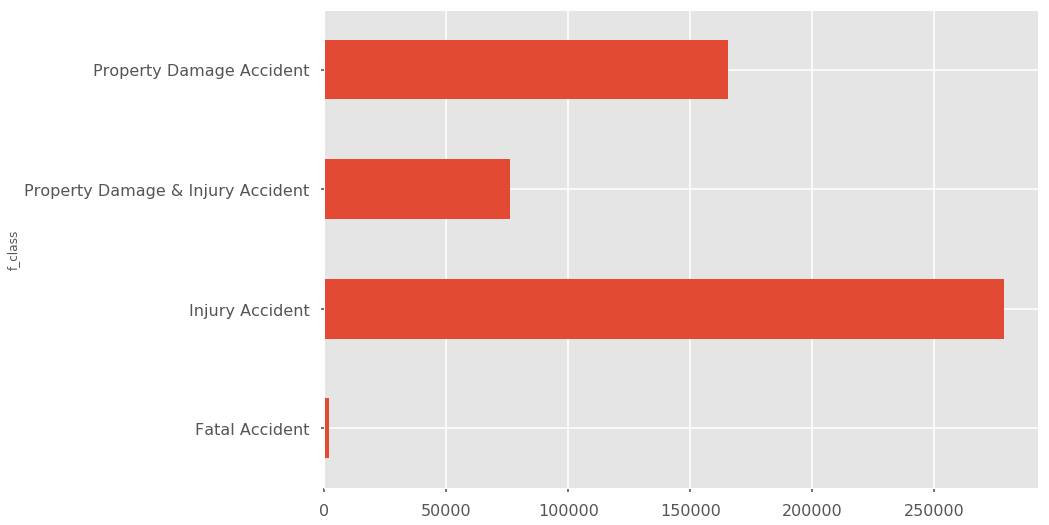

In [7]:
crash.groupby('f_class').count()[['CS_ID']].plot(kind='barh',legend=False)

In [8]:
crash['year']=crash.CSACCDTE.str[:4]
crash['day']=crash.CSACCDTE.str[8:10]
crash['month']=crash.CSACCDTE.str[5:7]
crash['date'] = pd.to_datetime(crash[['year','month','day']])

crash.date.min(), crash.date.max()

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


(Timestamp('2007-01-01 00:00:00'), Timestamp('2013-12-31 00:00:00'))

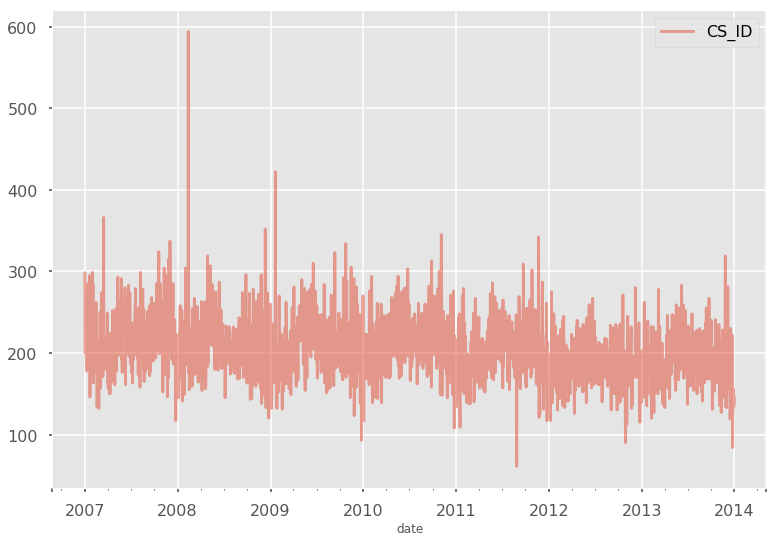

In [9]:
crash.groupby('date').count()[['CS_ID']].plot(alpha=.5)

In [10]:
df = crash.groupby('date').count()[['CS_ID']]
df[df.CS_ID>350]

,CS_ID
date,
2007-03-16,366
2008-02-12,594
2008-12-11,352
2009-01-20,422


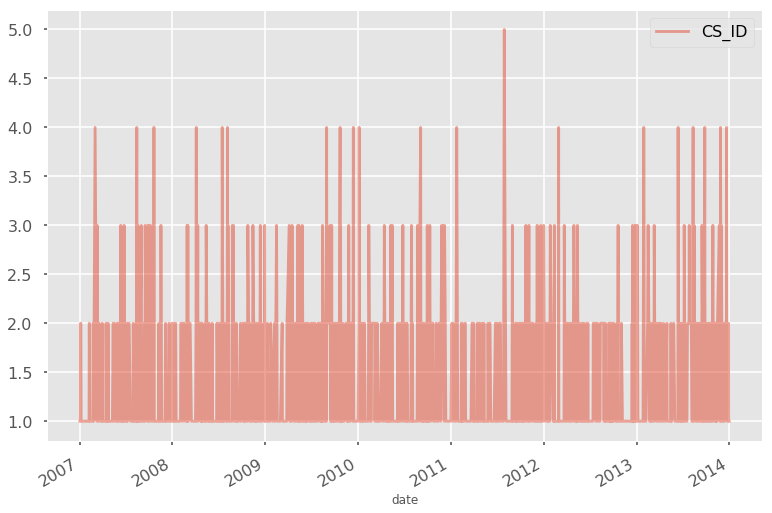

In [11]:
fatal = crash[crash.f_class=='Fatal Accident']
fatal.groupby('date').count()[['CS_ID']].plot(alpha=.5)

In [12]:
df = fatal.groupby('date').count()[['CS_ID']]
df[df.CS_ID>4]

,CS_ID
date,
2011-07-30,5


In [13]:
crash.groupby(crash.date.apply(lambda x: x.year)).count()[['CS_ID']]

,CS_ID
date,
2007,79510
2008,76468
2009,75539
2010,78342
2011,73055
2012,68795
2013,70399


narrow down to dates covered by matched data 2011-2013

In [14]:
crashTP = crash[crash.date>=pd.datetime(year=2011,month=1,day=1)]
crashTP.date.min(), crashTP.date.max()

(Timestamp('2011-01-01 00:00:00'), Timestamp('2013-12-31 00:00:00'))

In [15]:
crashTP.shape

(212249, 27)

In [16]:
crashTP.groupby('f_class').count()[['CS_ID']]

,CS_ID
f_class,
Fatal Accident,784
Injury Accident,116643
Property Damage & Injury Accident,29352
Property Damage Accident,65470


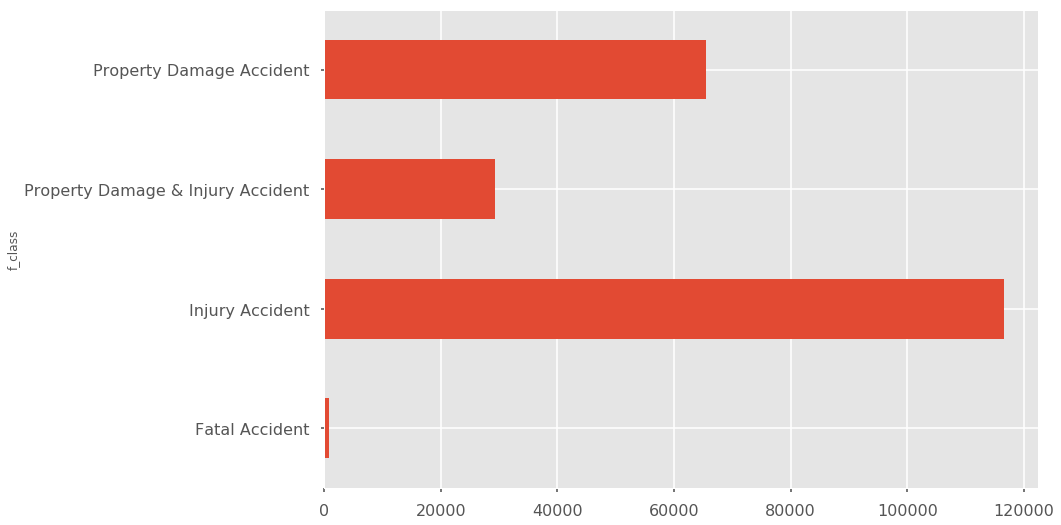

In [17]:
crashTP.groupby('f_class').count()[['CS_ID']].plot(kind='barh',legend=False)

contains around 350 more fatals than in the matched dataset

In [18]:
crashPR = crashTP[crashTP.POL_REPT=='Y']
crashPR.shape

(155546, 27)

In [19]:
crashPR.groupby('f_class').count()[['CS_ID']]

,CS_ID
f_class,
Fatal Accident,784
Injury Accident,100385
Property Damage & Injury Accident,23495
Property Damage Accident,30882


In [20]:
ind.head()

,CS_ID,CI_ID,CV_ID,EMTNSTATT_CDE,CIROLET_ID,STPSTNT_ID,EJCTT_ID,CI_LICENSE_STATE_CDE,CI_SEX_CDE,SFTYEQPT_ID,SEVERITY,INDIV_AGE,EMST_CDE,INJT_ID,INJLOCT_CDE,HOSP,ORG_HOSP_CDE,LAGSTP,LAGSEV,LAGEMS,LAGINJT,LAGHOSP
0,32088863,30431,6059995,None,15,1,None,None,None,None,O,None,None,None,None,None,None,None,.,.,None,None
1,32089687,30443,6061752,None,15,1,None,None,None,None,O,None,None,None,None,None,None,None,.,.,None,None
2,32089986,30447,6062247,None,15,1,None,None,None,None,O,None,None,None,None,None,None,None,.,.,None,None
3,32090042,30448,6062336,None,15,1,None,None,None,None,O,None,None,None,None,None,None,None,.,.,None,None
4,32090124,30449,6062468,None,15,1,None,None,None,None,O,None,None,None,None,None,None,None,.,.,None,None


In [21]:
ind.fillna('-').groupby('CI_SEX_CDE').count()[['CI_ID']]

,CI_ID
CI_SEX_CDE,
-,93700
C,9
F,525880
M,874280
O,1
U,1988
f,2359
m,4567
u,9


In [22]:
moda.attributes(veh)

,count,unique values
CS_ID,1092922,522109
CV_ID,1092922,1092922
VEHBDYT_ID,1092922,64
REGT_CDE,1092922,64
PACCACTT_ID,1092922,23
TBCT_DMV_CDE,1092922,28
DIRCTT_CDE,1092922,12
FT_ID,1092114,10
CV_VEH_YEAR,812236,72
CV_REG_STATE_CDE,952400,118


In [23]:
vehTP = veh[veh.CS_ID.isin(crashTP.CS_ID)]

In [24]:
moda.attributes(vehTP)

,count,unique values
CS_ID,444297,212249
CV_ID,444297,444297
VEHBDYT_ID,444297,58
REGT_CDE,444297,57
PACCACTT_ID,444297,22
TBCT_DMV_CDE,444297,17
DIRCTT_CDE,444297,11
FT_ID,443523,9
CV_VEH_YEAR,381860,63
CV_REG_STATE_CDE,412465,72


In [25]:
vehTP.groupby('VIN').count().sort_values('CS_ID',ascending=False)[['CS_ID']][:200]

,CS_ID
VIN,
2FABP7AVXBX,240
2FABP7AV3BX,216
2FABP7AV4BX,214
2FABP7AV0BX,210
2FABP7AV1BX,205
2FABP7AV7BX,200
2FABP7AV8BX,192
2FABP7AV6BX,191
2FABP7AV9BX,183


In [26]:
moda.attributes(vehTP)

,count,unique values
CS_ID,444297,212249
CV_ID,444297,444297
VEHBDYT_ID,444297,58
REGT_CDE,444297,57
PACCACTT_ID,444297,22
TBCT_DMV_CDE,444297,17
DIRCTT_CDE,444297,11
FT_ID,443523,9
CV_VEH_YEAR,381860,63
CV_REG_STATE_CDE,412465,72


In [27]:
vehTP.groupby('VEHBDYT_ID').count()

,CS_ID,CV_ID,REGT_CDE,PACCACTT_ID,TBCT_DMV_CDE,DIRCTT_CDE,FT_ID,CV_VEH_YEAR,CV_REG_STATE_CDE,CV_WEIGHT_LBS,CV_PSGR_NUM,CV_CYLNDR,CV_VEHMAKE_DESCR,CFT_CDE1,CFT_CDE2,SHZMTT_ID,VEH_EVNTT_ID,VIN,DMV_VIN_NUM
VEHBDYT_ID,,,,,,,,,,,,,,,,,,,
-3,772,772,772,772,772,772,0,0,0,0,0,0,0,689,685,0,685,0,0
1,1951,1951,1951,1951,1951,1951,1951,1187,1861,0,1951,54,1189,1649,1284,0,1352,55,0
10,4652,4652,4652,4652,4652,4652,4652,4297,4581,0,4652,3553,4297,4131,3411,0,3326,3553,0
101,34215,34215,34215,34215,34215,34215,34214,20982,20985,0,34214,1,20982,28878,22873,0,22796,1,0
102,592,592,592,592,592,592,592,396,396,0,592,0,396,511,429,0,417,0,0
103,11227,11227,11227,11227,11227,11227,11227,7172,7173,0,11227,0,7172,10118,8014,0,7718,0,0
12,5,5,5,5,5,5,5,3,5,0,5,0,3,4,3,0,3,0,0
13,38,38,38,38,38,38,38,38,38,0,38,38,38,33,31,0,28,38,0
14,10,10,10,10,10,10,10,5,9,0,10,0,5,5,5,0,5,0,0


In [28]:
vehTP[vehTP.VEHBDYT_ID=='5']

,CS_ID,CV_ID,VEHBDYT_ID,REGT_CDE,PACCACTT_ID,TBCT_DMV_CDE,DIRCTT_CDE,FT_ID,CV_VEH_YEAR,CV_REG_STATE_CDE,CV_WEIGHT_LBS,CV_PSGR_NUM,CV_CYLNDR,CV_VEHMAKE_DESCR,CFT_CDE1,CFT_CDE2,SHZMTT_ID,VEH_EVNTT_ID,VIN,DMV_VIN_NUM
616090,33727551,9159312,5,16,10,-3,E,1,1990,NY,None,-2,4,PLYMO,-2,-2,None,-2,2P4FH25K2LR,None
616543,33731812,9166772,5,16,1,-3,S,1,1994,NY,None,2,6,CHEVR,27,None,None,None,1GNDU06DXRT,None
617580,33763032,9226356,5,68,1,-3,E,1,2004,NY,None,4,6,HONDA,4,None,None,-2,5FNRL18074B,None
617731,33751053,9201803,5,16,8,-3,W,1,2002,NY,None,1,8,FORD,None,None,None,None,1FMDU73W72U,None
618553,33758704,9216933,5,16,1,-3,S,1,2001,NY,None,4,6,TOYOT,-1,None,None,None,4T3ZF13C61U,None
618555,33758744,9217001,5,16,-1,-3,-1,1,2002,NY,None,1,6,NISSA,None,None,None,None,5N1ED28Y12C,None
618557,33758746,9217007,5,16,1,-3,S,1,2003,NY,None,1,6,HYUND,17,None,None,None,KM8SC73D63U,None
618558,33758746,9217008,5,16,1,-3,W,1,1997,NY,None,4,6,NISSA,17,None,None,None,4N2DN1113VD,None
618697,33763704,9227871,5,16,-1,-3,-1,1,1993,NY,None,3,6,CHEVR,None,None,None,None,1GNDM19W7PB,None
618698,33763704,9227872,5,16,1,-3,W,1,2003,NY,None,2,6,FORD,None,None,None,None,1FMZU73K23U,None


In [29]:
moda.attributes(ind)

,count,unique values
CS_ID,1502797,522108
CI_ID,1502797,1502797
CV_ID,1502797,1092923
EMTNSTATT_CDE,1410632,9
CIROLET_ID,1502797,8
STPSTNT_ID,1284690,12
EJCTT_ID,1410632,6
CI_LICENSE_STATE_CDE,901659,217
CI_SEX_CDE,1409097,9
SFTYEQPT_ID,1290998,19


In [30]:
indTP = ind[ind.CS_ID.isin(crashTP.CS_ID)]

In [31]:
moda.attributes(indTP)

,count,unique values
CS_ID,607981,212249
CI_ID,607981,607981
CV_ID,607981,444297
EMTNSTATT_CDE,569968,9
CIROLET_ID,607981,8
STPSTNT_ID,607981,12
EJCTT_ID,569968,6
CI_LICENSE_STATE_CDE,363166,183
CI_SEX_CDE,569524,8
SFTYEQPT_ID,529628,19


In [32]:
indTP.groupby(['SEVERITY','EMTNSTATT_CDE']).count()[['CI_ID']]

CI_ID
SEVERITY EMTNSTATT_CDE        
A        -1                  1
         -3               1063
         2                 913
         3                1661
         4                 946
         5                 391
         6                6153
B        -3               1376
         5                 500
         6               17620
C        -1                  2
         -2                  9
         -3              31442
         5                2979
         6              130662
K        -1                 25
         -3                  1
         1                 403
         2                 268
         3                  42
         4                   9
         5                   5
         6                  80
O        -1               1768
         -2                326
         -3             356423
         6                8155
Z        -1               5189
         -2                  8
         -3                 73
         6                1475

In [33]:
indTP.groupby(['SEVERITY']).count()[['CI_ID']]

,CI_ID
SEVERITY,
A,11128
B,19496
C,165094
K,833
O,404685
Z,6745


In [34]:
indTP.fillna('-').groupby(['INJT_ID']).count()[['CI_ID']]

,CI_ID
INJT_ID,
-,78354
-1,9131
-2,2677
-3,313772
1,209
10,6013
11,4929
12,100120
13,35948


In [35]:
# injury type 16, 17, 18 are from Civilian MV104 (not police report)

civil = indTP[indTP.INJT_ID.isin(['16','17','18'])]

crash[crash.CS_ID.isin(civil.CS_ID)].groupby('POL_REPT').count()

,CS_ID,NYSACCT_ID,CSACCTIME,CSACCDTE,ACCDAY,HR1,MIN1,LGHTCNDT_ID,MUNIT_ID,CLSNMNRT_ID,CS_CNTYT_ID,RDSYST_ID,RDCHART_ID,WTHRT_ID,TFCCTRLT_ID,RDSRFT_ID,CS_REF_MARKER,PBLOCT_ID,PBACTT_DMV_CDE,EVNTT_ID,VEH_CNT,f_class,year,day,month,date
POL_REPT,,,,,,,,,,,,,,,,,,,,,,,,,,
N,22108,22108,21346,22108,22108,20185,20185,22108,22108,22108,22108,0,22108,22108,22108,22108,1412,7984,22108,22108,22108,22108,22108,22108,22108,22108
Y,4986,4986,4981,4986,4986,4957,4957,4986,4986,4986,4986,0,4986,4986,4986,4986,714,2188,4986,4986,4986,4986,4986,4986,4986,4986


In [36]:
crashTP.groupby('POL_REPT').count()

,CS_ID,NYSACCT_ID,CSACCTIME,CSACCDTE,ACCDAY,HR1,MIN1,LGHTCNDT_ID,MUNIT_ID,CLSNMNRT_ID,CS_CNTYT_ID,RDSYST_ID,RDCHART_ID,WTHRT_ID,TFCCTRLT_ID,RDSRFT_ID,CS_REF_MARKER,PBLOCT_ID,PBACTT_DMV_CDE,EVNTT_ID,VEH_CNT,f_class,year,day,month,date
POL_REPT,,,,,,,,,,,,,,,,,,,,,,,,,,
N,56703,56703,53006,56703,56703,47120,47120,56703,56703,56703,56703,0,56703,56703,56703,56703,3186,20689,56703,56701,56703,56703,56703,56703,56703,56703
Y,155546,155546,155413,155546,155546,155072,155072,155546,155546,155546,155546,0,155546,155546,155546,155546,17379,52366,155546,155533,155546,155546,155546,155546,155546,155546


In [37]:
indPR = indTP[indTP.CS_ID.isin(crashPR.CS_ID)&(~indTP.INJT_ID.isin(['16','17','18']))]
moda.attributes(indPR)

,count,unique values
CS_ID,462814,155499
CI_ID,462814,462814
CV_ID,462814,327338
EMTNSTATT_CDE,444249,9
CIROLET_ID,462814,8
STPSTNT_ID,462814,12
EJCTT_ID,444249,6
CI_LICENSE_STATE_CDE,266860,174
CI_SEX_CDE,443940,7
SFTYEQPT_ID,423101,19


In [38]:
moda.attributes(crashTP)

,count,unique values
CS_ID,212249,212249
NYSACCT_ID,212249,4
CSACCTIME,208419,1440
CSACCDTE,212249,1096
ACCDAY,212249,7
HR1,202192,24
MIN1,202192,60
LGHTCNDT_ID,212249,7
MUNIT_ID,212249,5
CLSNMNRT_ID,212249,12


In [39]:
moda.attributes(vehTP)

,count,unique values
CS_ID,444297,212249
CV_ID,444297,444297
VEHBDYT_ID,444297,58
REGT_CDE,444297,57
PACCACTT_ID,444297,22
TBCT_DMV_CDE,444297,17
DIRCTT_CDE,444297,11
FT_ID,443523,9
CV_VEH_YEAR,381860,63
CV_REG_STATE_CDE,412465,72


## 2 vehicle crashes

In [40]:
crashTP.shape

(212249, 27)

In [41]:
crashTP.groupby('VEH_CNT').count()[['CS_ID']]/float(crashTP.shape[0])*100

,CS_ID
VEH_CNT,
1,25.754656
10,0.004240
11,0.002356
12,0.000942
13,0.000471
14,0.001413
2,64.179808
3,7.669765
4,1.787052


In [42]:
# combining data using person info at the row level.

base = indPR.drop(['ORG_HOSP_CDE','LAGSTP','LAGINJT','LAGHOSP'],axis=1)

#merging in crash info
base = base.merge(crashTP.drop(['RDSYST_ID'],axis=1),
                  how='left',on='CS_ID')
print base.shape

# only keeping 2 veh crashes
twoVeh = base[base.VEH_CNT=='2']

# merging in own vehicle info
twoVeh = twoVeh.merge(vehTP.drop(['CV_WEIGHT_LBS','SHZMTT_ID','DMV_VIN_NUM','CS_ID'],
                             axis=1),
                  how='left',on='CV_ID')

twoVeh = twoVeh[(twoVeh.VEHBDYT_ID.astype(int)<100)&(twoVeh.VEHBDYT_ID.astype(int)>0)]

print twoVeh.shape


# other vehicle info
# only keeping motor vehicles (not pedestrians etc) 
vehMotor = vehTP[(vehTP.VEHBDYT_ID.astype(int)<100)&(vehTP.VEHBDYT_ID.astype(int)>0)]
vehMotor = vehMotor.drop(['CV_WEIGHT_LBS','SHZMTT_ID','DMV_VIN_NUM'],axis=1)

#dataframe to join crash and vehicle id's
cv = crashTP[crashTP.VEH_CNT=='2'][['CS_ID']].merge(vehMotor[['CS_ID','CV_ID']],
                                           how='left',on='CS_ID')
cv.columns=['CS_ID','CV2_ID']

twoVeh = twoVeh.merge(cv,how='left',on='CS_ID')
print twoVeh.shape

twoVeh = twoVeh[~(twoVeh.CV_ID==twoVeh.CV2_ID)]
print twoVeh.shape

twoVeh = twoVeh.merge(vehMotor.add_suffix('_other'),
                  how='left',left_on='CV2_ID',right_on='CV_ID_other')

print twoVeh.shape

(462814, 43)
(267170, 58)
(534033, 59)
(266863, 59)
(266863, 76)


In [43]:
# number of people involved in 2 vehicle crashes
indPR[indPR.CS_ID.isin(crashTP[crashTP.VEH_CNT=='2'].CS_ID)].shape

(268707, 22)

## pedestrian crashes

In [44]:
base.groupby('CIROLET_ID').count()

,CS_ID,CI_ID,CV_ID,EMTNSTATT_CDE,STPSTNT_ID,EJCTT_ID,CI_LICENSE_STATE_CDE,CI_SEX_CDE,SFTYEQPT_ID,SEVERITY,INDIV_AGE,EMST_CDE,INJT_ID,INJLOCT_CDE,HOSP,LAGSEV,LAGEMS,NYSACCT_ID,CSACCTIME,CSACCDTE,ACCDAY,HR1,MIN1,LGHTCNDT_ID,MUNIT_ID,CLSNMNRT_ID,CS_CNTYT_ID,RDCHART_ID,WTHRT_ID,TFCCTRLT_ID,RDSRFT_ID,CS_REF_MARKER,PBLOCT_ID,PBACTT_DMV_CDE,EVNTT_ID,VEH_CNT,POL_REPT,f_class,year,day,month,date
CIROLET_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,238329,238329,238329,238329,238329,238329,236976,238272,237648,238329,237363,237647,237648,237648,237647,238329,238329,238329,238160,238329,238329,237695,237695,238329,238329,238329,238329,238329,238329,238329,238329,34614,80373,238329,238302,238329,238329,238329,238329,238329,238329,238329
11,24279,24279,24279,24279,24279,24279,22739,24033,3818,24279,22330,3818,3818,3818,3818,24279,24279,24279,24253,24279,24279,24165,24165,24279,24279,24279,24279,24279,24279,24279,24279,538,8107,24279,24279,24279,24279,24279,24279,24279,24279,24279
14,61,61,61,61,61,61,0,61,61,61,51,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,0,32,61,61,61,61,61,61,61,61,61
15,18565,18565,18565,0,18565,0,0,0,0,18565,0,0,0,0,0,18565,18565,18565,18536,18565,18565,18462,18462,18565,18565,18565,18565,18565,18565,18565,18565,1307,6064,18565,18565,18565,18565,18565,18565,18565,18565,18565
2,137745,137745,137745,137745,137745,137745,0,137745,137745,137745,125120,137745,137745,137745,137744,137745,137745,137745,137656,137745,137745,137353,137353,137745,137745,137745,137745,137745,137745,137745,137745,19594,47715,137745,137745,137745,137745,137745,137745,137745,137745,137745
6,32660,32660,32660,32660,32660,32660,5076,32656,32656,32660,29068,32656,32656,32656,32655,32660,32660,32660,32634,32660,32660,32573,32573,32660,32660,32660,32660,32660,32660,32660,32660,155,10564,32660,32660,32660,32660,32660,32660,32660,32660,32660
7,10624,10624,10624,10624,10624,10624,1986,10623,10624,10624,9354,10624,10624,10624,10624,10624,10624,10624,10615,10624,10624,10594,10594,10624,10624,10624,10624,10624,10624,10624,10624,30,3410,10624,10624,10624,10624,10624,10624,10624,10624,10624
9,551,551,551,551,551,551,83,550,549,551,490,549,549,549,549,551,551,551,551,551,551,549,549,551,551,551,551,551,551,551,551,1,166,551,551,551,551,551,551,551,551,551


In [45]:
# only keeping 1 veh crashes
print base.shape
ped = base[(base.CIROLET_ID.isin(['6','7','14']))&(base.VEH_CNT=='1')]
print ped.shape

# bring in other vehicle info

#dataframe to join crash and vehicle id's
cv1 = crashTP[crashTP.VEH_CNT=='1'][['CS_ID']].merge(vehMotor[['CS_ID','CV_ID']],
                                           how='left',on='CS_ID')
cv1.columns=['CS_ID','CV2_ID']

ped = ped.merge(cv1,how='left',on='CS_ID')
print ped.shape

ped = ped[~(ped.CV_ID==ped.CV2_ID)]
print ped.shape

ped = ped.merge(vehMotor.add_suffix('_other'),
                how='left',left_on='CV2_ID', right_on='CV_ID_other')
print ped.shape

(462814, 43)
(41848, 43)
(41848, 44)
(41848, 44)
(41848, 61)


In [51]:
base[(base.CIROLET_ID.isin(['6','7','14']))].shape

(43345, 43)

In [52]:
base.shape

(462814, 43)

In [46]:
ind.groupby('SEVERITY').count()

,CS_ID,CI_ID,CV_ID,EMTNSTATT_CDE,CIROLET_ID,STPSTNT_ID,EJCTT_ID,CI_LICENSE_STATE_CDE,CI_SEX_CDE,SFTYEQPT_ID,INDIV_AGE,EMST_CDE,INJT_ID,INJLOCT_CDE,HOSP,ORG_HOSP_CDE,LAGSTP,LAGSEV,LAGEMS,LAGINJT,LAGHOSP
SEVERITY,,,,,,,,,,,,,,,,,,,,,
A,28093,28093,28093,28093,28093,23985,28093,12889,28089,28093,26339,28092,28093,28093,11338,27,1,28093,28093,1,0
B,46136,46136,46136,46136,46136,39817,46136,18309,46130,46136,42967,46136,46136,46136,19670,18,0,46136,46136,0,0
C,410456,410456,410456,410456,410456,350255,410456,223116,410442,410456,388152,410449,410456,410456,166517,179,26,410456,410456,26,15
K,1933,1933,1933,1933,1933,1665,1933,729,1933,1932,1864,1932,1932,1932,1664,268,0,1933,1933,0,0
O,1001436,1001436,1001436,909271,1001436,855966,909271,639989,907761,789638,870155,789637,789637,789637,326451,39,36,1001436,1001436,36,17
Z,14743,14743,14743,14743,14743,13002,14743,6627,14742,14743,13735,14743,14743,14743,6879,7,0,14743,14743,0,0


In [47]:
ind[ind.SEVERITY.isin(['K','A','B','C'])].shape

(486618, 22)

In [48]:
ind[ind.SEVERITY.isin(['K','A','B','C'])].shape[0]/7

69516

In [49]:
ind[ind.SEVERITY.isin(['K','A','B','C'])].CS_ID.nunique()/7

48154

In [50]:
crashid = crash[crash.year=='2013'].CS_ID
ind[(ind.SEVERITY.isin(['K','A','B','C']))&(ind.CS_ID.isin(crashid))].nunique()


CS_ID                   46202
CI_ID                   64774
CV_ID                   52759
EMTNSTATT_CDE               8
CIROLET_ID                  7
STPSTNT_ID                 12
EJCTT_ID                    6
CI_LICENSE_STATE_CDE       98
CI_SEX_CDE                  6
SFTYEQPT_ID                19
SEVERITY                    4
INDIV_AGE                  95
EMST_CDE                   11
INJT_ID                    20
INJLOCT_CDE                16
HOSP                       91
ORG_HOSP_CDE                0
LAGSTP                      0
LAGSEV                      1
LAGEMS                      1
LAGINJT                     0
LAGHOSP                     0
dtype: int64